In [1]:
!pip install torch torchvision

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision

import datasets

In [3]:
use_cuda = False
device = torch.device('cuda' if use_cuda else 'cpu')

# Experiment 1: Image Classification

In [67]:
# Default parameters from the PyTorch MNIST example (https://github.com/pytorch/examples/blob/master/mnist/main.py
params = dict(batch_size=64, batch_size_eval=1000, num_epochs=30, learning_rate=0.01, momentum=0.5)

## Load MNIST data and make a noisy variant

In [224]:
train_dataset, val_dataset, test_dataset = datasets.load_mnist()

In [327]:
train_dataset, val_dataset, test_dataset = datasets.load_emnist()

In [330]:
kwargs = {'num_workers': 3, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=params['batch_size_eval'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)

In [255]:
noisy_test_dataset = datasets.load_noisy_mnist(scaling_factor=2)
noisy_test_loader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)

In [331]:
noisy_test_dataset = datasets.load_noisy_emnist(scaling_factor=2)
noisy_test_loader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)

## Networks

In [230]:
class FeedforwardNet(nn.Module):
    # TODO: Add ability to easily add more hidden layers. 
    def __init__(self, num_hidden=500, dropout=0.5):
        super(FeedforwardNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 26)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.forward1(x))
        x = self.dropout(x)
        x = self.forward2(x)
        # TODO: Maybe change to loss function that includes softmax. 
        return F.log_softmax(x, dim=1)

In [73]:
class FeedbackNet(nn.Module):
    def __init__(self, num_hidden=500, dropout=0.5):
        super(FeedbackNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 10)
        self.dropout = nn.Dropout(dropout)
        
        self.feedback1 = nn.Linear(num_hidden, 784)
        self.feedback2 = nn.Linear(10, num_hidden)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        inp = inp.view(-1, 784)
        
        x = F.relu(self.forward1(inp))
        feedback_activation_1 = self.feedback1(x)
        
        x = self.dropout(x)
        x = F.log_softmax(self.forward2(x), dim=1)
        feedback_activation_2 = self.feedback2(x)
        # TODO: Maybe change to loss function that includes softmax. 
        
        #print(feedback_activation_1.shape, feedback_activation_2.shape)
        
        # 2nd forward pass, this time with added feedback
        x = F.relu(self.forward1(inp + feedback_activation_1))
        # TODO: Do dropout again here or only on the first pass?
        #x = F.dropout(x, training=self.training)
        x = F.log_softmax(self.forward2(x + feedback_activation_2), dim=1)
        
        return x
        

In [74]:
class ConvNet(nn.Module):
    """ConvNet from the official PyTorch tutorial, achieves around 98 % accuracy on test set (https://github.com/pytorch/examples/blob/master/mnist/main.py)."""
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Training

In [231]:
def train(model, device, train_loader, optimizer, epoch, params=None):
    model.train()
    for batch, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # TODO: Change to loss_function = ..., loss_function(output, target)
        #print(output.shape, target.shape)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(data), len(train_loader.dataset),
                100. * batch / len(train_loader), loss.item()))

In [232]:
def test(model, device, test_loader, params=None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # TODO: Change to loss_function = ..., loss_function(output, target)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [235]:
def count_parameters(model):
    return sum(p.numel() for p in filter(lambda p: p.requires_grad, model.parameters()) if p.requires_grad)

In [250]:
import time

model = FeedforwardNet(num_hidden=500).to(device)
#model = FeedbackNet().to(device)
print('Model has', count_parameters(model), 'trainable parameters')

# TODO: Maybe use Adam or Adadelta instead. 
optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])

for epoch in range(params['num_epochs']):
    print('Epoch {}/{}'.format(epoch+1, params['num_epochs']))
    start_time = time.time()
    train(model, device, train_loader, optimizer, epoch+1)
    print('Took', time.time()-start_time, 'seconds')
    test(model, device, test_loader)
    print('Now testing on noisy dataset...')
    test(model, device, noisy_test_loader)

Model has 405526 trainable parameters
Epoch 1/30
Train Epoch: 1 [0/114800 (0%)]	Loss: 3.364546
Train Epoch: 1 [6400/114800 (6%)]	Loss: 1.883056
Train Epoch: 1 [12800/114800 (11%)]	Loss: 1.774883
Train Epoch: 1 [19200/114800 (17%)]	Loss: 1.521679
Train Epoch: 1 [25600/114800 (22%)]	Loss: 1.308522
Train Epoch: 1 [32000/114800 (28%)]	Loss: 1.216146
Train Epoch: 1 [38400/114800 (33%)]	Loss: 0.981548
Train Epoch: 1 [44800/114800 (39%)]	Loss: 1.251293
Train Epoch: 1 [51200/114800 (45%)]	Loss: 1.232695
Train Epoch: 1 [57600/114800 (50%)]	Loss: 1.112284
Train Epoch: 1 [64000/114800 (56%)]	Loss: 0.856672
Train Epoch: 1 [70400/114800 (61%)]	Loss: 0.995457
Train Epoch: 1 [76800/114800 (67%)]	Loss: 1.025760
Train Epoch: 1 [83200/114800 (72%)]	Loss: 0.955970
Train Epoch: 1 [89600/114800 (78%)]	Loss: 0.967802
Train Epoch: 1 [96000/114800 (84%)]	Loss: 0.763317
Train Epoch: 1 [102400/114800 (89%)]	Loss: 0.982318
Train Epoch: 1 [108800/114800 (95%)]	Loss: 0.898482
Took 18.13324499130249 seconds

Test s

Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=L size=28x28 at 0x11B654390>>
Traceback (most recent call last):
  File "/Users/jrieke/anaconda2/envs/py3/lib/python3.6/site-packages/PIL/Image.py", line 587, in __del__
    if (hasattr(self, 'fp') and hasattr(self, '_exclusive_fp')
KeyboardInterrupt


Train Epoch: 4 [44800/114800 (39%)]	Loss: 0.494759
Train Epoch: 4 [51200/114800 (45%)]	Loss: 0.500844
Train Epoch: 4 [57600/114800 (50%)]	Loss: 0.732430
Train Epoch: 4 [64000/114800 (56%)]	Loss: 0.646362
Train Epoch: 4 [70400/114800 (61%)]	Loss: 0.496812
Train Epoch: 4 [76800/114800 (67%)]	Loss: 0.557956
Train Epoch: 4 [83200/114800 (72%)]	Loss: 0.721928
Train Epoch: 4 [89600/114800 (78%)]	Loss: 0.537880
Train Epoch: 4 [96000/114800 (84%)]	Loss: 0.474111
Train Epoch: 4 [102400/114800 (89%)]	Loss: 0.480194
Train Epoch: 4 [108800/114800 (95%)]	Loss: 0.340640
Took 20.938366413116455 seconds

Test set: Average loss: 0.4398, Accuracy: 18040/20800 (87%)

Now testing on noisy dataset...

Test set: Average loss: 5.2038, Accuracy: 465/10000 (5%)

Epoch 5/30
Train Epoch: 5 [0/114800 (0%)]	Loss: 0.623673
Train Epoch: 5 [6400/114800 (6%)]	Loss: 0.547669
Train Epoch: 5 [12800/114800 (11%)]	Loss: 0.555407
Train Epoch: 5 [19200/114800 (17%)]	Loss: 0.599290
Train Epoch: 5 [25600/114800 (22%)]	Loss: 0.

KeyboardInterrupt: 

# Experiment 2: Sequential Image Classification

In [4]:
params = dict(batch_size=64, batch_size_eval=1000, num_epochs=30, learning_rate=0.01, momentum=0.5)

## Make sequential dataset from EMNIST

In [5]:
def to_letter(index):
    return 'abcdefghijklmnopqrstuvwxyz'[index]

def to_index(letter):
    return ord(letter) - 97

In [6]:
num_allowed_seqs = 10
seq_len = 5
num_classes = 26  # mnist: 10, emnist: 26

allowed_seqs = np.random.randint(0, num_classes, (num_allowed_seqs, seq_len))

In [25]:
allowed_seqs_letters = np.loadtxt('data/5-letter-words.txt', dtype=str)
# Use only 10 words for now.
allowed_seqs_letters = np.random.choice(allowed_seqs_letters, 50)
allowed_seqs = np.array([list(map(to_index, word)) for word in allowed_seqs_letters])

In [26]:
allowed_seqs[:10], allowed_seqs_letters[:10]

(array([[18, 19, 14, 17, 12],
        [ 5, 17,  4, 18,  7],
        [17,  4,  5,  4, 17],
        [12,  8, 13, 14, 17],
        [22,  7,  4,  4, 11],
        [17,  4,  0,  2,  7],
        [12,  0,  6,  8,  2],
        [ 5,  8,  1,  4, 17],
        [20, 18,  0,  6,  4],
        [ 2,  7,  0,  8, 13]]),
 array(['storm', 'fresh', 'refer', 'minor', 'wheel', 'reach', 'magic',
        'fiber', 'usage', 'chain'], dtype='<U5'))

In [27]:
np.unique(allowed_seqs, return_counts=True)
# TODO: Some letters appear very rarely in these words, gotta keep this in mind when training only on sequences. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17,
        18, 19, 20, 21, 22, 24]),
 array([26,  5, 10,  8, 37,  6,  6, 11, 11,  1,  1,  9,  9, 12, 15,  4, 27,
        14, 16, 11,  2,  5,  4]))

In [28]:
train_dataset, val_dataset, test_dataset = datasets.load_emnist()
noisy_test_dataset = datasets.load_noisy_emnist(scaling_factor=4)

seq_train_dataset = datasets.ImageSequenceDataset(allowed_seqs, train_dataset, num_classes, num_samples=50000)
seq_test_dataset = datasets.ImageSequenceDataset(allowed_seqs, test_dataset, num_classes, num_samples=10000)
noisy_seq_test_dataset = datasets.ImageSequenceDataset(allowed_seqs, test_dataset, num_classes, num_samples=10000, noisy_image_dataset=noisy_test_dataset)

kwargs = {'num_workers': 3, 'pin_memory': True} if use_cuda else {}
seq_train_loader = torch.utils.data.DataLoader(seq_train_dataset, batch_size=params['batch_size'], shuffle=True, **kwargs)
seq_test_loader = torch.utils.data.DataLoader(seq_test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)
noisy_seq_test_loader = torch.utils.data.DataLoader(noisy_seq_test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)

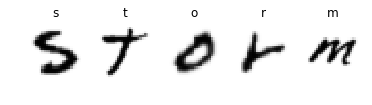

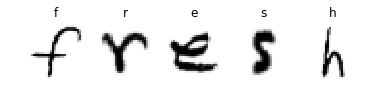

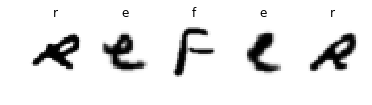

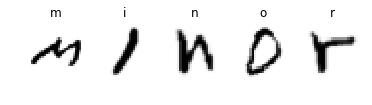

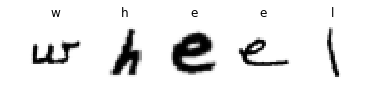

In [29]:
for i in range(5):
    plt.figure()
    datasets.plot_sequence(*seq_test_dataset[i], target_transform=to_letter)

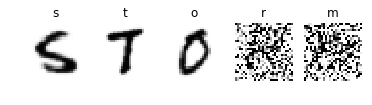

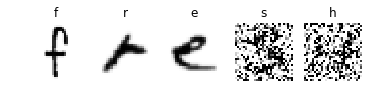

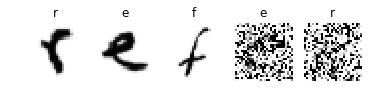

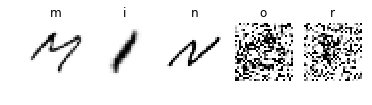

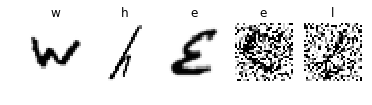

In [30]:
for i in range(5):
    plt.figure()
    datasets.plot_sequence(*noisy_seq_test_dataset[i], target_transform=to_letter)

## Networks

In [14]:
class SequentialLSTM(nn.Module):
    def __init__(self, num_hidden=500):
        super(SequentialLSTM, self).__init__()
        # TODO: Maybe change everything to batch_second.
        self.lstm1 = nn.LSTM(784, num_hidden, batch_first=True)
        self.lstm2 = nn.LSTM(num_hidden, 10, batch_first=True)
        
    def forward(self, inp):
        inp = inp.view(inp.shape[0], inp.shape[1], 784)
        #print(inp.shape)
        x, (hidden, cell) = self.lstm1(inp)
        # TODO: Need to add a non-linearity here?
        x, (hidden, cell) = self.lstm2(x)
        #print(x.shape, hidden.shape, cell.shape)
        #print(x.shape)
        x = F.log_softmax(x, dim=2)
        #print(x.sum(dim=(2)))
        return x

In [15]:
class SequentialFeedforwardNet(nn.Module):
    def __init__(self, num_hidden=500, dropout=0.5):
        super(SequentialFeedforwardNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 26)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        outp = torch.zeros(inp.shape[0], inp.shape[1], 26)
        
        for i, x in enumerate(inp.transpose(0, 1)):
            x = x.view(-1, 784)
            x = F.relu(self.forward1(x))
            x = self.dropout(x)
            x = self.forward2(x)
            # TODO: Maybe change to loss function that includes softmax. 
            x = F.log_softmax(x, dim=1)
            outp[:, i] = x
            
        return outp

In [17]:
class SequentialFeedbackNet(nn.Module):
    def __init__(self, num_hidden=500, dropout=0.5, alpha=0.5):
        super(SequentialFeedbackNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 26)
        self.dropout = nn.Dropout(dropout)
        
        self.feedback1 = nn.Linear(num_hidden, 784)
        self.feedback2 = nn.Linear(26, num_hidden)
        self.alpha = alpha
        
        self.dropout = nn.Dropout(dropout)
        self.no_feedback = False
        
    def forward(self, inp):
        outp = torch.zeros(inp.shape[0], inp.shape[1], 26)
        
        feedback_activation_1 = torch.zeros(inp.shape[0], self.forward1.weight.shape[1])
        feedback_activation_2 = torch.zeros(inp.shape[0], self.forward2.weight.shape[1])
        
        for i, x in enumerate(inp.transpose(0, 1)):
            x = x.view(-1, 784)
            #print(feedback_activation_1.mean())
            x = F.relu(self.forward1((1 - self.alpha) * x + self.alpha * feedback_activation_1))
            # TODO: Is this retained across forward passes?
            feedback_activation_1 = self.feedback1(x)  # for next forward pass
            x = self.dropout(x)
            x = self.forward2(x)
            #x = self.forward2((1 - self.alpha) * x +  self.alpha * feedback_activation_2)
            # TODO: Maybe change to loss function that includes softmax. 
            x = F.log_softmax(x, dim=1)
            feedback_activation_2 = self.feedback2(x)  # for next forward pass
            outp[:, i] = x
            
        return outp

In [54]:
imgs = seq_train_dataset[0][0]
model = SequentialFeedbackNet()
model.forward1.weight.data = ff_model.forward1.weight.data.clone()
model.forward1.bias.data = ff_model.forward1.bias.data.clone()
model.forward2.weight.data = ff_model.forward2.weight.data.clone()
model.forward2.bias.data = ff_model.forward2.bias.data.clone()
model(imgs[None], no_feedback=False)

NameError: name 'ff_model' is not defined

## Training

In [63]:
# Good template for hyperparameter optimization:
#def run(train_dataset, val_dataset, device, params, history)
#def 

In [18]:
# TODO: Debug properly.
def train_sequential(model, device, train_loader, optimizer, epoch, params=None):
    model.train()
    for batch, (data, target) in enumerate(seq_train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        #print(output.shape, target.shape)
        
        # TODO: According to https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
        #       need to do model.zero_grad() and model.hidden = model.init_hidden() here. 

        loss = F.nll_loss(output.transpose(1, 2), target)  # loss function requires transpose
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(data), len(train_loader.dataset),
                100. * batch / len(train_loader), loss.item()))

In [19]:
# TODO: Debug properly.
def test_sequential(model, device, test_loader, per_position=False, params=None):
    model.eval()
    test_loss = 0
    correct = 0
    if per_position:
        correct_per_position = torch.zeros(seq_len)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.transpose(1, 2), target, reduction='sum').item() # sum up batch loss, loss function requires transpose
            
            pred = output.view(-1, output.shape[-1]).max(1, keepdim=True)[1].view_as(target) # get the index of the max log-probability
            correct += (pred == target).sum().item()
            if per_position:
                correct_per_position += (pred == target).float().sum(0)

    # TODO: Make this independent of seq_len (used twice!).
    test_loss /= len(test_loader.dataset) * seq_len
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f} %)'.format(
        test_loss, correct, len(test_loader.dataset) * seq_len,
        100. * correct / (len(test_loader.dataset) * seq_len)))
    if per_position:
        print('Accuracy per position:', ' | '.join(['{:.1f} %'.format(100. * corr.item() / len(test_loader.dataset)) for corr in correct_per_position]))

In [17]:
len([p for p in model.parameters() if p.requires_grad])

NameError: name 'model' is not defined

In [ ]:
#model = SequentialFeedforwardNet().to(device)
#model = SequentialLSTM().to(device)
model = SequentialFeedbackNet(dropout=0.5, alpha=0.5).to(device)
# TODO: Use rmsprop or another optimizer which is good for LSTMs.
#optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.0001, momentum=params['momentum'])
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=params['momentum'])

for epoch in range(params['num_epochs']):
    print('Epoch {}/{}'.format(epoch+1, params['num_epochs']))
    start_time = time.time()
    train_sequential(model, device, seq_train_loader, optimizer, epoch+1)
    print('Took', time.time()-start_time, 'seconds')
    
    print()
    test_sequential(model, device, seq_test_loader, per_position=True)
    print()
    print('Now testing on noisy dataset...')
    test_sequential(model, device, noisy_seq_test_loader, per_position=True)
    print()

Epoch 1/30
Train Epoch: 1 [0/50000 (0%)]	Loss: 3.245282
Train Epoch: 1 [6400/50000 (13%)]	Loss: 3.133655
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.798897
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.672216
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.460414
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.166460
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.002362
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.971108
Took 15.9791898727417 seconds

Test set: Average loss: 1.7280, Accuracy: 24982/50000 (50.0 %)
Accuracy per position: 45.5 % | 53.9 % | 45.2 % | 60.2 % | 45.0 %

Now testing on noisy dataset...
Test set: Average loss: 2.0542, Accuracy: 20137/50000 (40.3 %)
Accuracy per position: 45.4 % | 54.7 % | 45.3 % | 34.6 % | 21.4 %

Epoch 2/30
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.777502
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.716708
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.673282
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.625030
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.508195
Train Epoch: 2 [3

Train Epoch: 12 [19200/50000 (38%)]	Loss: 0.538315
Train Epoch: 12 [25600/50000 (51%)]	Loss: 0.707225
Train Epoch: 12 [32000/50000 (64%)]	Loss: 0.587210
Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.634721
Train Epoch: 12 [44800/50000 (90%)]	Loss: 0.566732
Took 18.761394739151 seconds

Test set: Average loss: 0.4298, Accuracy: 44671/50000 (89.3 %)
Accuracy per position: 89.1 % | 90.1 % | 88.3 % | 90.0 % | 89.2 %

Now testing on noisy dataset...
Test set: Average loss: 6.6141, Accuracy: 33459/50000 (66.9 %)
Accuracy per position: 88.2 % | 90.3 % | 88.1 % | 40.2 % | 27.7 %

Epoch 13/30
Train Epoch: 13 [0/50000 (0%)]	Loss: 0.595614
Train Epoch: 13 [6400/50000 (13%)]	Loss: 0.636469
Train Epoch: 13 [12800/50000 (26%)]	Loss: 0.791741
Train Epoch: 13 [19200/50000 (38%)]	Loss: 0.657595
Train Epoch: 13 [25600/50000 (51%)]	Loss: 0.780811
Train Epoch: 13 [32000/50000 (64%)]	Loss: 0.570334
Train Epoch: 13 [38400/50000 (77%)]	Loss: 0.649971
Train Epoch: 13 [44800/50000 (90%)]	Loss: 0.607718
Took 18.3

Train Epoch: 23 [32000/50000 (64%)]	Loss: 0.841937
Train Epoch: 23 [38400/50000 (77%)]	Loss: 0.778566
Train Epoch: 23 [44800/50000 (90%)]	Loss: 0.782976
Took 19.059797048568726 seconds

Test set: Average loss: 0.4677, Accuracy: 44516/50000 (89.0 %)
Accuracy per position: 88.4 % | 88.4 % | 87.8 % | 90.5 % | 90.1 %

Now testing on noisy dataset...
Test set: Average loss: 8.4504, Accuracy: 34453/50000 (68.9 %)
Accuracy per position: 87.0 % | 88.0 % | 87.8 % | 46.4 % | 35.2 %

Epoch 24/30
Train Epoch: 24 [0/50000 (0%)]	Loss: 0.763712
Train Epoch: 24 [6400/50000 (13%)]	Loss: 0.876846
Train Epoch: 24 [12800/50000 (26%)]	Loss: 0.783085
Train Epoch: 24 [19200/50000 (38%)]	Loss: 0.750002
Train Epoch: 24 [25600/50000 (51%)]	Loss: 0.723164
Train Epoch: 24 [32000/50000 (64%)]	Loss: 0.848686
Train Epoch: 24 [38400/50000 (77%)]	Loss: 0.696207
Train Epoch: 24 [44800/50000 (90%)]	Loss: 0.695448
Took 18.432995080947876 seconds

Test set: Average loss: 0.4805, Accuracy: 44434/50000 (88.9 %)
Accuracy per

In [376]:
%debug

> <ipython-input-332-6b89f492fa14>(28)<listcomp>()
     25         if self.add_noise:
     26             images = [random.choice(self.images_per_class[class_]) for class_ in seq[:3]] + [random.choice(self.noisy_images_per_class[class_]) for class_ in seq[3:]]
     27         else:
---> 28             images = [random.choice(self.images_per_class[class_]) for class_ in seq]
     29         return torch.cat(images), seq

ipdb> class_
-32
ipdb> q


In [236]:
model = SequentialFeedbackNet(dropout=0, alpha=0.5).to(device)

In [237]:
model.forward1.weight.data = ff_model.forward1.weight.data.clone()
model.forward1.bias.data = ff_model.forward1.bias.data.clone()
model.forward2.weight.data = ff_model.forward2.weight.data.clone()
model.forward2.bias.data = ff_model.forward2.bias.data.clone()

In [242]:
test_sequential(model, device, seq_test_loader, params)


Test set: Average loss: 0.5467, Accuracy: 46727/10000 (93%)



In [126]:
model.forward1.weight.requires_grad = False
model.forward1.bias.requires_grad = False
model.forward2.weight.requires_grad = False
model.forward2.bias.requires_grad = False


Test set: Average loss: 0.5414, Accuracy: 46792/10000 (94%)



In [86]:
#ff_model = model

In [239]:
test(ff_model, device, test_loader, params)


Test set: Average loss: 0.1806, Accuracy: 9459/10000 (95%)

